In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


**Importing Data**

In [3]:
path = "/content/drive/MyDrive/Fintech Proj2/stock_data.csv"
data = pd.read_csv(path)
data

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


Text Cleaning

In [50]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag 
swords = set(stopwords.words("english"))

def text_processing(raw_string):
  #Remove hyperlinks
  output = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_string, flags=re.MULTILINE)
  #Remove non alphanumeric characters
  output = "".join(char for char in output if ord(char) < 128 and not char.isnumeric())
  #Remove stopwords
  #output = " ".join(word for word in output.split() if word not in swords)
  #Lemmatization
  def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
  lemmatizer = WordNetLemmatizer()
  output = list(map(lambda w: lemmatizer.lemmatize(w[0], pos = get_wordnet_pos(w[1])), pos_tag(output.split())))
  output = ' '.join(output)
  return output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
[('car', 'N'), ('ant', 'V')]

In [51]:
X_raw = data['Text'].to_numpy()
X_raw = list(map(text_processing, X_raw))

Y = data['Sentiment'].to_numpy()
Y[Y == -1] = 0

(len(X_raw),len(Y))

(5791, 5791)

Train Test Split

In [52]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, Y,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

(len(X_train_raw),len(X_test_raw),len(y_train),len(y_test))

(4632, 1159, 4632, 1159)

Tokenization

In [53]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_raw)
# Get our training data word index
word_index = tokenizer.word_index

In [54]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_raw)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_raw)

Padding

In [55]:
max_length = 30
padding_type='post'
truncation_type='post'

X_test = pad_sequences(X_test_tokenized,maxlen=max_length,padding=padding_type, truncating=truncation_type)
X_train = pad_sequences(X_train_tokenized,maxlen=max_length,padding=padding_type, truncating=truncation_type)

Word Embedding (GloVe)

In [56]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-12-13 16:23:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-13 16:23:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-13 16:23:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [57]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [58]:
#Retrieve GloVe embedding index from file
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [59]:
#Create embedding matrix which matches words from the word_index dictionary to their corresponding GloVe embedding vectors
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Tensorflow Model

In [76]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64,return_sequences = True)), 
    Bidirectional(LSTM(64)), 
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
   Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
145/145 [==============================] - 21s 84ms/step - loss: 0.7114 - accuracy: 0.5978 - val_loss: 0.6670 - val_accuracy: 0.6316
Epoch 2/20
145/145 [==============================] - 10s 72ms/step - loss: 0.6015 - accuracy: 0.6805 - val_loss: 0.5895 - val_accuracy: 0.6652
Epoch 3/20
145/145 [==============================] - 10s 72ms/step - loss: 0.5615 - accuracy: 0.7118 - val_loss: 0.5580 - val_accuracy: 0.7135
Epoch 4/20
145/145 [==============================] - 10s 72ms/step - loss: 0.5304 - accuracy: 0.7355 - val_loss: 0.6316 - val_accuracy: 0.6859
Epoch 5/20
145/145 [==============================] - 13s 86ms/step - loss: 0.4914 - accuracy: 0.7638 - val_loss: 0.5146 - val_accuracy: 0.7506
Epoch 6/20
145/145 [==============================] - 10s 72ms/step - loss: 0.4490 - accuracy: 0.7830 - val_loss: 0.9491 - val_accuracy: 0.6928
Epoch 7/20
145/145 [==============================] - 10s 72ms/step - loss: 0.4156 - accuracy: 0.8003 - val_loss: 0.5310 - val_accuracy:

Validation Accuracy: 0.7385677099227905


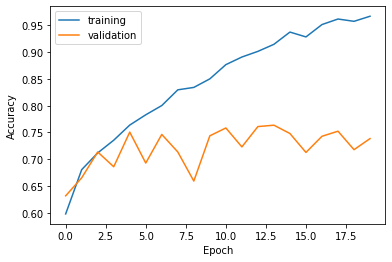

In [152]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],label="training")
plt.plot(history.history["val_accuracy"],label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
print("Validation Accuracy: "+ str(history.history["val_accuracy"][-1]))